# Arabic Kids Stories SLM

In [2]:
!pip install -U datasets transformers

# Data loading

In [3]:
from datasets import load_dataset, DatasetDict

DATASET_NAME = "arbml/Arabic_Stories_Corpus"
DATASET_CONFIG = None
SUBSAMPLE_TRAIN = 1.0
SUBSAMPLE_VAL = 1.0

loaded_dataset_name, raw_datasets = None, None
raw_datasets = load_dataset(DATASET_NAME, DATASET_CONFIG)
if not isinstance(raw_datasets, DatasetDict):
    raw_datasets = DatasetDict({"train": raw_datasets})

if "validation" in raw_datasets:
    dataset = DatasetDict({"train": raw_datasets["train"], "validation": raw_datasets["validation"]})
elif "val" in raw_datasets:
    dataset = DatasetDict({"train": raw_datasets["train"], "validation": raw_datasets["val"]})
elif "test" in raw_datasets:
    dataset = DatasetDict({"train": raw_datasets["train"], "validation": raw_datasets["test"]})
else:
    split_ds = raw_datasets["train"].train_test_split(test_size=0.1, seed=42, shuffle=True)
    dataset = DatasetDict({"train": split_ds["train"], "validation": split_ds["test"]})

if SUBSAMPLE_TRAIN < 1.0:
    dataset["train"] = dataset["train"].shuffle(seed=42).select(range(int(len(dataset["train"]) * SUBSAMPLE_TRAIN)))
if SUBSAMPLE_VAL < 1.0:
    dataset["validation"] = dataset["validation"].shuffle(seed=42).select(range(int(len(dataset["validation"]) * SUBSAMPLE_VAL)))

print(f"Using dataset: {DATASET_NAME}")
print({split: len(dset) for split, dset in dataset.items()})


Using dataset: arbml/Arabic_Stories_Corpus
{'train': 52, 'validation': 6}


In [4]:
# Identify the text/story field so tokenization works regardless of column naming
TEXT_CANDIDATES = ["story", "Story", "text", "content", "body", "description", "narration", "sentence", "Story"]
train_columns = dataset["train"].column_names
for name in TEXT_CANDIDATES:
    if name in train_columns:
        TEXT_FIELD = name
        break
else:
    raise ValueError(f"Could not find a story text column in {train_columns}")

print(f"Using text field: {TEXT_FIELD}")
dataset["train"][0][TEXT_FIELD]


Using text field: body


'\nتمشي .. تحث الخطى .. تلتصق بالجدار الرطب .. تنصت أكثر .. لعل الصوت يدلها على مصدر الضوء الخافت الذي كلما تدنو منه ويخالجها إحساس أنها وصلت .. تفاجأ أنها لا تزال بعيدة. \nنقاط مطرية باردة تهطل على رأسها وكتفيها .. تزاد أحيانا وتكون غزيرة .. وتكاد أحيانا أن تتوقف .. ترفع عباءتها وتغطي رأسها لتحمي نفسها من البلل ولكن عباءتها تجمع مياه المطر لتسيل على ثوبها فيرتجف بردا جسدها المرتجف خوفا .. رائحة المطر غريبة في البيوت الخربة .. بيوت بلا أسقف أو أبواب أو نوافذ .. بقايا خربة لبيوت كانت ذات يوم عامرة .. قدماها تغوصان في بحيرات المياه الصغيرة التي تملأ الأزقة والمداخل .. مزيج من الطين والوحل يلطخ ساقيها وثيابها .. تتابع السير .. نباح كلب يليه مواء قطة وأصوات تلاطم وتدافع . \n" ما الذي جاء بي إلى هذه الخرابة ؟.. حمقاء .. مجنونة .. لا .. بل الشيطان الذي يسكن عقلي هو الذي يقود خطاي .. لعنة الله علي وعلى أفكاري " \nتتأرجح بين العودة والاستمرار .. تود أن تكشف أمرا فكرت طويلا به \n" سأستمر .. وليكن ما يكون" \nتنتقل بين الغرف .. تستنشق الهواء عله يحمل عطرا .. تتوخى الحرص في خطوتها فقد تدوس على صدى

In [5]:
import re
safe_prefix = re.sub(r"[^A-Za-z0-9]+", "_", str(loaded_dataset_name)).strip("_") or "arabic_stories"
print(f"Bin prefix base: {safe_prefix}")


Bin prefix base: None


# Tokenization and binning
We stick with the byte-pair encoding flow: tokenize every story, stream ids to `.bin` files via memory-mapped arrays, and reuse cached bins on reruns.

In [6]:
from tqdm.auto import tqdm
from transformers import AutoTokenizer
import os
import numpy as np

from pathlib import Path
import re
safe_prefix = re.sub(r"[^A-Za-z0-9]+", "_", str('arbml/Arabic_Stories_Corpus')).strip("_") or "arabic_stories"

tokenizer = AutoTokenizer.from_pretrained("aubmindlab/aragpt2-base")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

BIN_PREFIX = f"{safe_prefix}_stories"
TRAIN_BIN = f"{BIN_PREFIX}_train.bin"
VAL_BIN = f"{BIN_PREFIX}_validation.bin"

In [7]:
REBUILD_BINS = True  # set True to force regenerating bin files when tokenizer/data changes
# set to False to reuse existing bins if unchanged

In [8]:
def processing(sample_text):
    ids = tokenizer.encode(sample_text[TEXT_FIELD], add_special_tokens=False)
    return {"ids": ids, "len": len(ids)}

In [9]:
columns_to_remove = [c for c in train_columns if c != TEXT_FIELD]
if REBUILD_BINS or not (os.path.exists(TRAIN_BIN) and os.path.exists(VAL_BIN)):
    if REBUILD_BINS:
        for f in [TRAIN_BIN, VAL_BIN]:
            if os.path.exists(f):
                os.remove(f)
                print(f"Removed stale bin: {f}")
    tokenized = dataset.map(
        processing,
        remove_columns=columns_to_remove,
        desc="tokenizing splits",
        num_proc=4,
    )
    for split_name, dset in tokenized.items():
        arr_len = np.sum(dset["len"], dtype=np.uint64)
        filename = TRAIN_BIN if split_name == "train" else VAL_BIN
        dtype = np.uint32  # room for the vocab ids without overflow
        arr = np.memmap(filename, dtype=dtype, mode="w+", shape=(arr_len,))
        total_batches = max(1, min(1024, len(dset)))  # avoid shard indices beyond dataset length
        idx = 0
        for batch_idx in tqdm(range(total_batches), desc=f"writing {filename}"):
            shard = dset.shard(num_shards=total_batches, index=batch_idx, contiguous=True).with_format("numpy")
            if len(shard) == 0:
                continue
            arr_batch = np.concatenate(shard["ids"])
            if len(arr_batch) == 0:
                continue
            arr[idx : idx + len(arr_batch)] = arr_batch
            idx += len(arr_batch)
        arr.flush()
else:
    print("Found existing bin files, reusing them.")

writing arbml_Arabic_Stories_Corpus_stories_train.bin:   0%|          | 0/52 [00:00<?, ?it/s]

writing arbml_Arabic_Stories_Corpus_stories_validation.bin:   0%|          | 0/6 [00:00<?, ?it/s]

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
from contextlib import nullcontext

# Choose model size; default to a lean variant between tiny and small to fit ~12GB
MODEL_VARIANT = "lean12"  # options: tiny, lean12, small, fit8gb, fit12gb, max12gb, medium, xl
VARIANTS = {
    "tiny":   {"n_layer": 6,  "n_head": 6,  "n_embd": 384,  "block_size": 128, "batch_size": 1},
    "lean12": {"n_layer": 8,  "n_head": 8,  "n_embd": 512,  "block_size": 192, "batch_size": 1},
    "small":  {"n_layer": 12, "n_head": 12, "n_embd": 768,  "block_size": 256, "batch_size": 1},
    "fit8gb": {"n_layer": 18, "n_head": 12, "n_embd": 768,  "block_size": 256, "batch_size": 1},
    "fit12gb": {"n_layer": 24, "n_head": 16, "n_embd": 1024, "block_size": 512, "batch_size": 1},
    "max12gb": {"n_layer": 28, "n_head": 16, "n_embd": 1280, "block_size": 512, "batch_size": 1},
    "medium": {"n_layer": 24, "n_head": 16, "n_embd": 1024, "block_size": 512, "batch_size": 1},
    "xl":     {"n_layer": 48, "n_head": 25, "n_embd": 1600, "block_size": 512, "batch_size": 1},
}
variant_cfg = VARIANTS[MODEL_VARIANT]

learning_rate = 1e-4
max_iters = 20000
warmup_steps = 2000
min_lr = 5e-4
eval_iters = 500
batch_size = variant_cfg["batch_size"]
block_size = variant_cfg["block_size"]
gradient_accumulation_steps = 32

n_layer = variant_cfg["n_layer"]
n_head = variant_cfg["n_head"]
n_embd = variant_cfg["n_embd"]

device = "cuda" if torch.cuda.is_available() else "cpu"
device_type = "cuda" if device == "cuda" else "cpu"
dtype = "bfloat16" if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else "float16"
ptdtype = {"float32": torch.float32, "bfloat16": torch.bfloat16, "float16": torch.float16}[dtype]
ctx = nullcontext() if device_type == "cpu" else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

print(f"Using variant {MODEL_VARIANT}: layers={n_layer}, heads={n_head}, embd={n_embd}, block_size={block_size}, batch_size={batch_size}")

torch.set_default_device(device)
torch.manual_seed(42)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
from contextlib import nullcontext

MODEL_VARIANT = "lean12"
VARIANTS = {
    "tiny":   {"n_layer": 6,  "n_head": 6,  "n_embd": 384,  "block_size": 128, "batch_size": 1},
    "lean12": {"n_layer": 8,  "n_head": 8,  "n_embd": 512,  "block_size": 192, "batch_size": 1},
    "small":  {"n_layer": 12, "n_head": 12, "n_embd": 768,  "block_size": 256, "batch_size": 1},
    "fit8gb": {"n_layer": 18, "n_head": 12, "n_embd": 768,  "block_size": 256, "batch_size": 1},
    "fit12gb": {"n_layer": 24, "n_head": 16, "n_embd": 1024, "block_size": 512, "batch_size": 1},
}
variant_cfg = VARIANTS[MODEL_VARIANT]

base_lr = 3e-4
lr_scale = variant_cfg["batch_size"] / 8.0
learning_rate = base_lr * max(lr_scale, 1e-2)
min_lr = learning_rate * 0.1
max_iters = 20000
warmup_steps = 2000
eval_iters = 500
batch_size = variant_cfg["batch_size"]
block_size = variant_cfg["block_size"]
gradient_accumulation_steps = 1

n_layer = variant_cfg["n_layer"]
n_head = variant_cfg["n_head"]
n_embd = variant_cfg["n_embd"]

device = "cuda" if torch.cuda.is_available() else "cpu"
device_type = "cuda" if device == "cuda" else "cpu"
dtype = "bfloat16" if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else "float16"
ptdtype = {"float32": torch.float32, "bfloat16": torch.bfloat16, "float16": torch.float16}[dtype]
ctx = nullcontext() if device_type == "cpu" else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

print(f"Variant {MODEL_VARIANT}: layers={n_layer}, heads={n_head}, embd={n_embd}, block={block_size}, bs={batch_size}, lr={learning_rate:.6f}")

torch.set_default_device(device)
torch.manual_seed(42)

Variant lean12: layers=8, heads=8, embd=512, block=192, bs=1, lr=0.000037


In [11]:
def get_batch(split):
    data = np.memmap(TRAIN_BIN if split == "train" else VAL_BIN, dtype=np.uint32, mode="r")
    data_len = len(data)
    if data_len <= 1:
        raise ValueError("Dataset too small after filtering; increase data or reduce filtering.")
    effective_block = min(block_size, data_len - 1)
    ix = torch.randint(data_len - effective_block, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i : i + effective_block]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i + 1 : i + 1 + effective_block]).astype(np.int64)) for i in ix])
    if device_type == "cuda":
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

# Model architecture
Same GPT-style stack as the TinyStories notebook: layer norm, causal self-attention, MLP, and residual connections.

In [12]:
class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)


In [13]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.flash = hasattr(F, "scaled_dot_product_attention")
        if not self.flash:
            self.register_buffer(
                "bias",
                torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size),
            )

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        if self.flash:
            y = F.scaled_dot_product_attention(
                q,
                k,
                v,
                attn_mask=None,
                dropout_p=self.attn_dropout.p if self.training else 0.0,
                is_causal=True,
            )
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float("-inf"))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v

        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y


In [14]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))


In [15]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embd, config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln2 = LayerNorm(config.n_embd, config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x


In [16]:
from dataclasses import dataclass

@dataclass
class GPTConfig:
    block_size: int
    vocab_size: int
    n_layer: int
    n_head: int
    n_embd: int
    dropout: float = 0.0
    bias: bool = True

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(
            dict(
                wte=nn.Embedding(config.vocab_size, config.n_embd),
                wpe=nn.Embedding(config.block_size, config.n_embd),
                drop=nn.Dropout(config.dropout),
                h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
                ln_f=LayerNorm(config.n_embd, config.bias),
            )
        )
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight

        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith("c_proj.weight"):
                nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size
        pos = torch.arange(0, t, dtype=torch.long, device=device)

        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            return logits, loss
        else:
            logits = self.lm_head(x[:, [-1], :])
            return logits, None

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size :]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float("inf")
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


In [17]:
config = GPTConfig(
    vocab_size=tokenizer.vocab_size,
    block_size=block_size,
    n_layer=n_layer,
    n_head=n_head,
    n_embd=n_embd,
    dropout=0.1,
    bias=True,
)

model = GPT(config).to(device)

# Training setup and perplexity helper

In [18]:
def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ["train", "validation"]:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch("train" if split == "train" else "validation")
                with ctx:
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean().item()
    model.train()
    return out


def loss_to_perplexity(loss_value):
    return math.exp(loss_value)


from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.1, eps=1e-9)
# Adaptive scheduler: reduce LR on validation plateau
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2, verbose=True, min_lr=1e-6)

scaler = torch.cuda.amp.GradScaler(enabled=(dtype == "float16" and device_type == "cuda"))


/home/wasfy/anaconda3/envs/slm/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_166777/1099187712.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == "float16" and device_type == "cuda"))


In [19]:
best_val_loss = float("inf")
best_train_loss = float("inf")
best_model_params_path = "arabic_best_model_params.pt"
train_loss_list, validation_loss_list = [], []
train_ppl_list, validation_ppl_list = [], []
bad_epochs = 0
early_stop_patience = 4
anomaly_factor = 2.0  # spike threshold vs best val
spike_resets = 0
max_spike_resets = 2  # how many times to halve LR on spikes before stopping

for step in tqdm(range(max_iters)):
    if step % eval_iters == 0 and step != 0:
        losses = estimate_loss(model)
        ppl = {split: loss_to_perplexity(val) for split, val in losses.items()}
        print(
            f"Step {step}: train loss {losses['train']:.4f} (ppl {ppl['train']:.2f}), "
            f"val loss {losses['validation']:.4f} (ppl {ppl['validation']:.2f}), lr {optimizer.param_groups[0]['lr']:.6f}"
        )
        train_loss_list.append(losses["train"])
        validation_loss_list.append(losses["validation"])
        train_ppl_list.append(ppl["train"])
        validation_ppl_list.append(ppl["validation"])

        if not math.isfinite(losses["validation"]):
            print("Stopping early due to non-finite validation loss.")
            break

        # spike handling: if val loss jumps a lot, try LR cut before stopping
        if best_val_loss < float("inf") and losses["validation"] > anomaly_factor * best_val_loss:
            if spike_resets < max_spike_resets:
                spike_resets += 1
                for g in optimizer.param_groups:
                    g['lr'] = max(g['lr'] * 0.5, 1e-6)
                bad_epochs = 0
                print(f"Validation spike detected. Reducing LR and continuing (spike reset {spike_resets}/{max_spike_resets}).")
            else:
                print("Stopping early due to repeated validation loss spikes.")
                break

        # save best and track patience
        if losses["validation"] < best_val_loss - 1e-4:
            best_val_loss = losses["validation"]
            torch.save(model.state_dict(), best_model_params_path)
            bad_epochs = 0
        else:
            bad_epochs += 1

        # scheduler step based on validation loss
        scheduler.step(losses["validation"])

        # early stop on plateau
        if bad_epochs >= early_stop_patience:
            print("Early stopping: validation loss did not improve.")
            break

    X, y = get_batch("train")

    with ctx:
        logits, loss = model(X, y)
        loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

    if ((step + 1) % gradient_accumulation_steps == 0) or (step + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)


  0%|          | 0/20000 [00:00<?, ?it/s]

Step 500: train loss 6.4966 (ppl 662.85), val loss 6.9047 (ppl 996.99), lr 0.000037
Step 1000: train loss 6.0572 (ppl 427.19), val loss 6.6684 (ppl 787.13), lr 0.000037
Step 1500: train loss 5.9746 (ppl 393.29), val loss 6.6683 (ppl 787.02), lr 0.000037
Step 2000: train loss 5.8344 (ppl 341.86), val loss 6.6274 (ppl 755.50), lr 0.000037
Step 2500: train loss 5.7704 (ppl 320.67), val loss 6.5887 (ppl 726.87), lr 0.000037
Step 3000: train loss 5.7680 (ppl 319.88), val loss 6.5711 (ppl 714.14), lr 0.000037
Step 3500: train loss 5.6859 (ppl 294.68), val loss 6.6565 (ppl 777.82), lr 0.000037
Step 4000: train loss 5.5691 (ppl 262.20), val loss 6.6710 (ppl 789.19), lr 0.000037
Step 4500: train loss 5.4756 (ppl 238.80), val loss 6.5684 (ppl 712.24), lr 0.000037
Step 5000: train loss 5.4192 (ppl 225.71), val loss 6.6577 (ppl 778.74), lr 0.000037
Step 5500: train loss 5.3780 (ppl 216.59), val loss 6.6488 (ppl 771.84), lr 0.000037
Step 6000: train loss 5.3321 (ppl 206.87), val loss 6.5606 (ppl 70

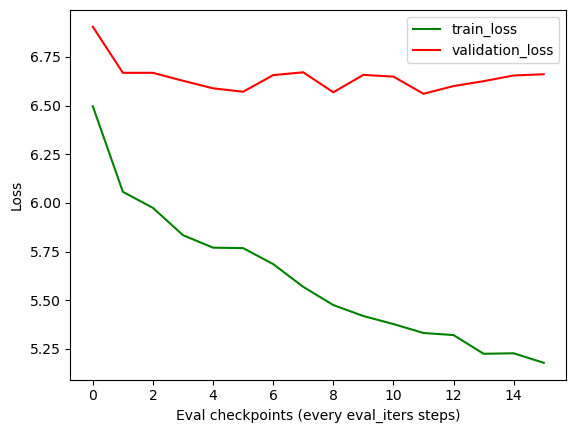

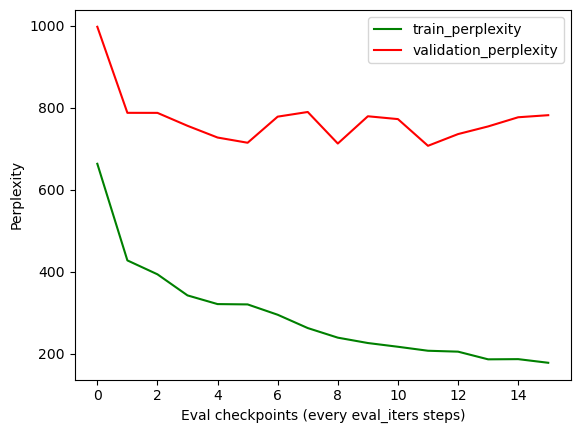

In [20]:
import matplotlib.pyplot as plt

plt.plot(train_loss_list, "g", label="train_loss")
plt.plot(validation_loss_list, "r", label="validation_loss")
plt.xlabel("Eval checkpoints (every eval_iters steps)")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_ppl_list, "g", label="train_perplexity")
plt.plot(validation_ppl_list, "r", label="validation_perplexity")
plt.xlabel("Eval checkpoints (every eval_iters steps)")
plt.ylabel("Perplexity")
plt.legend()
plt.show()


In [21]:
# Load the best checkpoint and report final perplexity
best_model = GPT(config).to(device)
best_model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device)))

final_eval = estimate_loss(best_model)
final_ppl = {split: loss_to_perplexity(val) for split, val in final_eval.items()}
print(f"Final evaluation -> train loss: {final_eval['train']:.4f}, val loss: {final_eval['validation']:.4f}")
print(f"Perplexity -> train: {final_ppl['train']:.2f}, val: {final_ppl['validation']:.2f}")


/tmp/ipykernel_166777/1607788438.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(

Final evaluation -> train loss: 5.3353, val loss: 6.5719
Perplexity -> train: 207.54, val: 714.70


In [22]:
# Generation on Arabic prompts with Arabic token allowlist and conservative sampling
import re

special_ids = set()
if tokenizer.pad_token_id is not None:
    special_ids.add(tokenizer.pad_token_id)
if tokenizer.eos_token_id is not None:
    special_ids.add(tokenizer.eos_token_id)

allowed_ids = []
allow_punct = ["", " ", "،", "؛", ".", ",", "؟", "!", "«", "»", "…", '"', "'"]
for i in range(tokenizer.vocab_size):
    decoded = tokenizer.decode([i], skip_special_tokens=False)
    if i in special_ids:
        allowed_ids.append(i)
        continue
    if re.search(r"[؀-ۿ]", decoded):
        allowed_ids.append(i)
        continue
    if decoded.strip() in allow_punct:
        allowed_ids.append(i)
allowed_ids = torch.tensor(allowed_ids, device=device)


def safe_softmax_logits(logits):
    logits = torch.where(torch.isnan(logits), torch.full_like(logits, float('-inf')), logits)
    if torch.isinf(logits).all():
        return torch.zeros_like(logits)
    return logits


def apply_repetition_penalty(logits, idx, penalty=1.15):
    if penalty == 1.0:
        return logits
    logits = logits.clone()
    if idx.numel() > 0:
        unique_ids = torch.unique(idx)
        logits[:, unique_ids] /= penalty
    return logits


def generate_arabic(prompt, max_new_tokens=120, temperature=0.4, top_k=20, top_p=0.85, repetition_penalty=1.15):
    idx = tokenizer.encode(prompt, add_special_tokens=False, return_tensors="pt").to(device)
    for _ in range(max_new_tokens):
        idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
        logits, _ = best_model(idx_cond)
        logits = logits[:, -1, :] / temperature
        logits = apply_repetition_penalty(logits, idx, penalty=repetition_penalty)

        mask = torch.full_like(logits, float('-inf'))
        mask.scatter_(1, allowed_ids.unsqueeze(0), 0.0)
        logits = logits + mask

        if top_k is not None:
            v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
            logits[logits < v[:, [-1]]] = float('-inf')

        if top_p is not None:
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            cumulative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)
            sorted_logits[cumulative_probs > top_p] = float('-inf')
            logits.scatter_(1, sorted_indices, sorted_logits)

        logits = safe_softmax_logits(logits)
        probs = torch.softmax(logits, dim=-1)
        if torch.isnan(probs).any() or torch.isinf(probs).any():
            probs = torch.ones_like(probs) / probs.size(-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, idx_next), dim=1)
    return tokenizer.decode(idx.squeeze().tolist())



In [23]:
print(generate_arabic("في قديم الزمان كان هناك طفل صغير يحب قراءة القصص عن الأبطال الشجعان."))


في قديم الزمان كان هناك طفل صغير يحب قراءة القصص عن الأبطال الشجعان.  ميليلوت . للنقاش و هي هذه المرة ، غادرت و كانت كل شيء في هذه المرة ، الليثها . 103 و لم يكن على الأرض ، العوامل ، Policy ، 2011ها .. 
  و هو لا أريد موص ، القوس و هو . تعالي البروتين .ايسبوك ، الإذن و هي لا بد كبيرا . احيسمحت . المهرجانات . كلفة ،لايب هذه الأرض ، أري . other شاركناه .اتف ، بطلان . القفزها .ORT ، سفن . وملتقى ، الاعلامية . الميز جريج .ثيوبيا ،لحفاة ،ستار . للهندسة ،ماغ .تمرين اللهجة ، العماد ، هذه الأرض .. و هي ؟! المتزايد .


In [24]:
print(generate_arabic("ذهبت الطفلة إلى الحديقة لتبحث عن زهرة سحرية تحقق الأمنيات."))

ذهبت الطفلة إلى الحديقة لتبحث عن زهرة سحرية تحقق الأمنيات.  مدويةها.
"  طرائق في كل والإسكان من هذه المرة.  فالأمر باستمرارها تصاعا من هذا هو كل كريم في هذا هو لا أريد باولوها يتم في كل والطلاب . يتشكل . وبطاقات ، وأبن بدل . واللقاءات . Han ، حبلنا . آسيوي ، هو في كل أخلاقه . ارتكبواها .انيته . المشتر . ونتيجة على أن يكون قد أائفة وايران . قيام الصحبةخوةها . رصاصت .ككه . والمناقشات . ترشيحها .بوع على الأرض و هي .. لحادث و هي المصلي . ومحلاتها . بالمؤسساتها . نموذها . اقتصاداتها و لم يكن . جزءا .
